In [2]:
from dask.distributed import Client
client = Client()
client

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38367 instead
  warnings.warn(


In [18]:
import numpy as np 
from constants import GRAV
import xarray as xr
import dask.array as da

PATH = "/scratch/users/robcking/gwd_u_era5_2010_2020.zarr"
LOON_MASK_PATH = "data/loon_masks.nc"

ds = xr.open_dataset(PATH,chunks={})
loon_ds = xr.open_dataset(LOON_MASK_PATH)
loon_ds = loon_ds.rename({'lat':'latitude','lon':"longitude"})

loon_ds['longitude'] = (loon_ds.longitude + 360) % 360 
loon_ds = loon_ds.sortby('longitude')

interp_mask = loon_ds.interp(latitude=ds.latitude,longitude=ds.longitude,method='nearest').astype(bool)


In [19]:
extr_gwd = ds.where(interp_mask.extratropical_pacific).stack(points = ['latitude','longitude'])
extr_gwd = extr_gwd.gwd.dropna('points',how='all')

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 27.65 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [22]:
extr_gwd.level.data[::-1]

array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,
        125,  150,  175,  200,  225,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  775,  800,  825,  850,  875,  900,
        925,  950,  975, 1000])

In [49]:
extr_gwd_flip = extr_gwd.isel(level=slice(None,None,-1))

In [67]:
cumulative_trapezoid(extr_gwd_flip/GRAV,axis=1,x=extr_gwd_flip.level,initial=0)

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 27.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [66]:
def integrate_along_axis(y):
    return cumulative_trapezoid(y, x=y.level,initial=0,axis=1)

extr_gwd_flip.map_blocks(integrate_along_axis,template=extr_gwd_flip)

AssertionError: 

In [ ]:
from scipy.integrate import cumulative_trapezoid
from ad99py import GRAV
## TODO: Check vertical integral w.r.t to p i think it's just 1/g 
def integrate_along_axis(y, x):
    return cumulative_trapezoid(y, x=x,initial=0,axis=1)

uw_ptv = da.map_blocks(integrate_along_axis,extr_gwd_flip/GRAV,x=extr_gwd_flip.level,dtype=extr_gwd.dtype,chunks=extr_gwd.chunks)

In [42]:
demo = uw_ptv[0,:,0].compute()

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 35.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025-02-24 12:36:11,696 - distributed.scheduler - ERROR - Task ('finalize-integrate_along_axis-getitem-a24ab4cca7a96b3cee9bf4b7363ddc7d', 0) has 90.23 GiB worth of input dependencies, but worker tcp://127.0.0.1:44511 has memory_limit set to 8.00 GiB. It seems like you called client.compute() on a huge collection. Consider writing to distributed storage or slicing/reducing first.


MemoryError: Task ('finalize-integrate_along_axis-getitem-a24ab4cca7a96b3cee9bf4b7363ddc7d', 0) has 90.23 GiB worth of input dependencies, but worker tcp://127.0.0.1:44511 has memory_limit set to 8.00 GiB. It seems like you called client.compute() on a huge collection. Consider writing to distributed storage or slicing/reducing first.

In [17]:
extr_gwd_1hpa = extr_gwd.sel(level=1,method='nearest')
extr_gwd_10hpa = extr_gwd.sel(level=10,method='nearest')
extr_gwd_100hpa = extr_gwd.sel(level=1,method='nearest')

In [19]:
extr_gwd_10hpa = extr_gwd_10hpa.gwd.dropna('points',how='all')

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 26.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [25]:
extr_gwd_10hpa_flt = extr_gwd_10hpa.data.ravel()

In [26]:
extr_gwd_10hpa_flt = extr_gwd_10hpa_flt.compute()

/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 27.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(-5.0, 5.0)

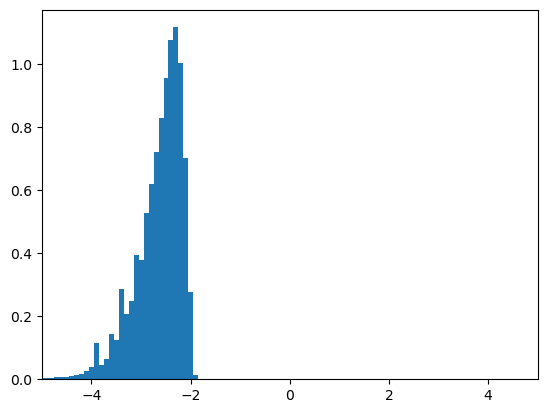

In [38]:
import matplotlib.pyplot as plt 
import numpy as np
extra_gwd_10hpa_flt = extr_gwd_10hpa_flt[extr_gwd_10hpa_flt > 0]
plt.hist(np.log10(1000*extra_gwd_10hpa_flt),bins=100,density=True)
plt.xlim(-5,5)